In [2]:
%matplotlib inline

import numpy as np # NUMPY
import pandas as pd # PANDAS
import matplotlib.pyplot as plt # MATPLOTLIB
import seaborn as sns # SEABORN
import scipy
import sklearn
import random as rd
from sklearn.decomposition import PCA
from IPython.display import display
import os 
from pathlib import Path
import shutil 
import cv2

# En este notebook, primero escribimos en un archivo los datos para mejor acceso, luego los alineamos, y luego conseguimos el atributo shape (b_shape ) de nuestras imagenes

## Luego aqui exploraremos como conseguir imagenes nuevas. Deberia ser conseguir los landmarks --> Usar procustres con la shape de referencia y alinear landmarks y warpear imagenes

## Assumptions :

Cada secuencia muestra 1 de las 6 emociones básicas

La primer frame de cada secuencia muestra  la cara en una expression neutral

La intensidad de la expresion aumenta en cada frame de un sujeto (siendo intesidad 1 el ultimo frame. Otros no asumen la mayor intensidad en ultimo frame, nosotros si)

Aca para imagen nueva vamos a tener que usar aam para conseguir los landmarks. Por ahora vamos a extraer el feature 
b_shape para nuestra c_mock que usaremos de entrenamiento (mock)

we need to understansd the landmarks (annotaste) and the aam for the test image (input images)
#TO DO

### Cargamos y formateamos datos en orden de la  ck+ database

#### Landmarks

In [11]:
subjects_landmarks = '../ck+copy/Landmarks/'
sorted_subjects =   np.sort(os.listdir('../ck+copy/Landmarks/')) # we probably need to not have the sorted



distances = []
for subject in sorted_subjects:
    one_subject_landmarks = '../ck+copy/Landmarks/' + str(subject)+ '/'
    sorted_list = np.sort(os.listdir(one_subject_landmarks)) #creo que este sort se puede quitar
    distances_per_subject = []
    for emotion in sorted_list:
        matrix_landmark_per_frame = []
        subject_landmark_emotion = one_subject_landmarks + str(emotion)    
        for i in range(0, len(os.listdir(subject_landmark_emotion))):
            data = pd.read_csv('../ck+copy/Landmarks/' +  str(subject)+ '/' + str(emotion)+'/'+ str(subject)+ '_'+str(emotion)+'_'+ str(i+1).zfill(8)+'_landmarks.txt',  header=None)
            data.columns =['landmarks']
            quantity_of_landmarks = data.size #68
            data = data['landmarks'].str.split('   ', expand=True)
            data.columns =['landmarks', 'landmarkX', 'landmarkY']
            data =data.drop(columns=['landmarks'])
            landmarkXY=data['landmarkX'].append(data['landmarkY'], ignore_index=True)
            landmarkXY_array =landmarkXY.to_numpy(dtype=float)
            matrix_landmark_per_frame.append(landmarkXY_array)                
        distances_per_subject.append(matrix_landmark_per_frame)
    distances.append(distances_per_subject)
#tenemos matrix que por cada sujeto tiene una matriz con cada emocion, que por cada distancia por emocion tiene vector con la distancia de frames con el primero por emocion

In [19]:
np.asarray(distances[1][0]).shape

(19, 136)

### Aca convertimos  en array y agrupamos por secuencia de imagenes

In [30]:
for i in range(0, len(distances)):
    for j in range(0, len( distances[i])):
        distances[i][j]= np.asarray( distances[i][j])
    distances[i]= np.asarray( distances[i])
distances= np.asarray( distances)
print(distances.shape)

(11,)


### Aca  convertimos en array y apilamos todos los frames de todas las secuencias

In [35]:
stacked_array = []
for i in range(0, len(distances)):
    if(len(distances[i])>0):
        stacked_array.append(np.vstack(distances[i])) 
stacked_array= np.asarray( stacked_array, dtype=object)
total_stacked_landmarkRawData = np.vstack(tuple(stacked_array))
print(total_stacked_landmarkRawData.shape)

(583, 136)


### El orden de rawData es [x1...xn, y1..yn]

In [41]:
my_df = pd.DataFrame(total_stacked_landmarkRawData)
my_df.to_csv('ckmock_landmark_rawData.csv',header = False, index= False)

### Aca  separamos las primeras frames de cada secuencia, ( cara  neutral), y la cantidad de frames por secuencia, para poder luego sacar las diferencia entre los landmarks de los frames de una secuencia  y el primer frame de esta (cara neutral). 

In [37]:
first_frame =[]
cant_frame_per_seq = []
for i in range(0, len(distances)):#aca no hay problema porque si es 0 lo saltea
    for j in range(0, len( distances[i])):
        first_frame.append(distances[i][j][0])
        cant_frame_per_seq.append(len(distances[i][j]))
        

first_frame = np.asarray( first_frame, dtype=object)
cant_frame_per_seq = np.asarray( cant_frame_per_seq, dtype=object)

In [40]:
first_frame.shape, cant_frame_per_seq


((32, 136),
 array([16, 22, 14, 21, 20, 13, 19, 16, 20, 17, 14, 23, 22, 11, 13, 20, 28,
        21, 14, 18, 13, 9, 15, 21, 10, 12, 17, 17, 16, 18, 18, 55],
       dtype=object))

In [42]:
my_df = pd.DataFrame(first_frame)
my_df.to_csv('ckmock_landmark_firstFrame.csv',header = False, index= False)

In [43]:
my_df = pd.DataFrame(cant_frame_per_seq)
my_df.to_csv('ckmock_landmark_FramePerSeq.csv',header = False, index= False)

### Aca sacamos las imagenes y hacemos un ejemplo para ver que se visualizen. Luego las alinearemos.

In [19]:

subjects_images = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images'
sorted_subjects =   np.sort(os.listdir('../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/')) # we probably need to not have the sorted

images = []

for subject in sorted_subjects:
    one_subject_images = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/' + str(subject)+ '/'
    sorted_list = np.sort(os.listdir(one_subject_images)) #creo que este sort se puede quitar
    images_per_subject = []
    for emotion in sorted_list:  
        if emotion != '.DS_Store':
            images__per_seqframe = []
            subject_image_emotion = one_subject_images + str(emotion)
            for i in range(0, len(os.listdir(subject_image_emotion))):            
                image = '../ck+copy/extended-cohn-kanade-images/cohn-kanade-images/' +  str(subject)+ '/' + str(emotion)+'/'+ str(subject)+ '_'+str(emotion)+'_'+ str(i+1).zfill(8)+'.png'
                images__per_seqframe.append(image)        
            images_per_subject.append(images__per_seqframe)
    if (len(images_per_subject)> 0):
        images.append(images_per_subject)   
       

In [20]:
#las pasamos a array
for i in range(0, len(images)):
    for j in range(0, len(images[i])):
                images[i][j]= np.asarray( images[i][j], dtype=object)
    images[i]= np.asarray( images[i], dtype=object)
images= np.asarray( images, dtype=object)

In [21]:
# las ponemos todas juntas
all_images = []
for i in range(0, len(images)):
    for j in range(0, len(images[i])):
        for r in range(0, len(images[i][j])):
            all_images.append(images[i][j][r])
        
        
all_images = np.asarray(all_images)
all_images.shape

(583,)

In [22]:
#See if loading image works
img= cv2.imread(images[0][0][0])

img =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_width, img_height = img.shape
print(img.shape)

cv2.imshow("Face landmark result", img)

# Pause screen to wait key from user to see result
cv2.waitKey(0)
cv2.destroyAllWindows()

(490, 640)


# Alineación de shapes con procustres.

## Ahora, para que todas nuestras imagenes estén alineadas, utilizamos Procustres analysis. 

Este analisis, en su version normal, utiliza una imagen de referencia y luego encuentra las transformaciones de rotacion,  translacion y escala que minimizen la diferencia con esa imagen 

(La versión generalizada en cambio ve las distancias de la aproximacion de entre todos los pares y elije la imagen cuyas distancias son menores ) 



EL procustres de spicy devuelve los landmarks corridos, pero no devuelve 
las matrices de trasnformación, que son necesarias para luego hacer warp de las imagenes
en tiempo polinomial.

Acá primero lo hacemos con spicy (normal) y luego con un computo de procustres.
(normal y generalizado)

Vemos las diferencias y como dan los b_shapes con cada uno.

Luego, tambien usamos la transformacion para warpear las imágenes, y trabajamos a partir de ahora
con las imagenes y landmarks alineados.

we have todo procustres and we need noormalization of the landmark differences, (la normalizacion es la resta)

In [23]:
my_data = pd.read_csv('ckmock_landmark_rawData.csv',header = None)
my_data #estas son las shapes sin la diferencia [x1...xl,y1..yl]

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,258.21331,261.55523,267.97811,276.75035,290.51988,310.56404,332.52056,363.12680,397.90211,430.61491,...,399.27606,381.07137,361.32769,343.84549,342.42136,344.78512,356.98614,367.24676,371.10579,367.88323
1,258.13275,261.42912,267.81342,276.54981,290.29515,310.33590,332.28497,362.90888,397.73641,430.50874,...,399.74673,381.44214,361.63632,344.10029,342.69826,345.10062,357.38444,367.69383,371.55997,368.28721
2,258.13275,261.42912,267.81342,276.54981,290.29515,310.33590,332.28497,362.90888,397.73641,430.50874,...,399.74673,381.44214,361.63632,344.10029,342.69826,345.10062,357.38444,367.69383,371.55997,368.28721
3,257.82910,261.24945,267.75741,276.62210,290.49315,310.64611,332.72098,363.45032,398.33004,431.12377,...,399.92405,381.73347,361.95912,344.42858,342.96012,345.28903,357.46670,367.74943,371.63609,368.45492
4,257.22100,260.65151,267.16515,276.04949,289.95150,310.08680,332.22743,363.10276,398.02856,430.91290,...,399.08309,381.30672,361.73390,344.66729,343.30180,345.55129,357.33861,367.09862,370.72880,367.69832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,115.86963,112.93274,117.17366,122.67064,127.33818,143.47229,171.46135,206.11647,243.01498,280.48308,...,373.63796,367.54380,348.19022,335.69261,337.04359,338.96399,348.94466,358.92533,360.84233,360.68783
579,115.66148,112.66714,116.91814,122.37381,126.99586,143.13366,171.10475,205.75984,242.65266,280.11895,...,373.52837,367.42105,348.11837,335.60194,336.98068,338.94873,348.93671,358.92469,360.77691,360.63480
580,115.43598,112.49343,116.67052,122.14295,126.77145,142.80359,170.74582,205.36372,242.23622,279.70164,...,373.31586,367.31479,347.96201,335.51023,336.92484,338.85964,348.76621,358.67277,360.52549,360.41379
581,115.11577,112.23193,116.45522,121.99641,126.69982,142.82142,170.81914,205.45261,242.34578,279.80245,...,373.88288,367.71043,348.26640,335.67124,336.99358,338.87440,348.96750,359.06061,361.10281,360.86157


### En estas 2 celdas cambiamos el formato, para tener los datos en forma intercalada (x1,y1,x2,y2) y xy (x1,x2..xn,y1,y2..yn). Usamos este último para b_shape como dice el paper, pero para procuestres lo usamos en orden intercalado (de a pares)

In [24]:
#Cambiamos a [x1, y1, x2,y2]
intercalated_data =[]
for i in range(0,len(my_data)):
    x_coord =my_data.iloc[i][0:int(len(my_data.iloc[i])/2)]
    y_coord = my_data.iloc[i][int(len(my_data.iloc[i])/2):len(my_data.iloc[i])]
    output = []
    for (a, b) in zip(x_coord, y_coord):
        output.append(a)
        output.append(b)
    intercalated_data.append(np.asarray(output))
intercalated_data = np.asarray(intercalated_data)
intercalated_data.shape

(583, 136)

In [25]:
my_df = pd.DataFrame(intercalated_data)
my_df.to_csv('ckmock_landmark_intercalated_data.csv',header = False, index= False)

In [26]:
#Ahora lo hacemos en pares
#Cambiamos a [x1, y1, x2,y2]
intercalated_data =[]
for i in range(0,len(my_data)):
    x_coord =my_data.iloc[i][0:int(len(my_data.iloc[i])/2)]
    y_coord = my_data.iloc[i][int(len(my_data.iloc[i])/2):len(my_data.iloc[i])]
    output = []
    for (a, b) in zip(x_coord, y_coord):
        output.append(np.array([a,b]))        
    intercalated_data.append(np.asarray(output))
intercalated_data = np.asarray(intercalated_data)
intercalated_data.shape

(583, 68, 2)

In [ ]:
Procustres
#Usamos la primera imagen como shape de referencia (puede generalizarse)

In [27]:

        
def opa(a, b):# a, b matrices de puntos [[],[],[]] a and b need to have same dimension
    aT = a.mean(0) # column mean [[1,2,3],[1,2,3]]<-(1,2,3)
    bT = b.mean(0)
    A = a - aT  #We rest aT and bT to center the matrix (translation)
    B = b - bT
    aS = np.sum(A * A)**.5 #to see the scale, we first calculate square of squared sum
    bS = np.sum(B * B)**.5
    A /= aS  #we standarize the scale.
    B /= bS
    U, _, V = np.linalg.svd(np.dot(B.T, A)) # we get the principal values of the mult for getting the rotation more close 
    aR = np.dot(U, V) #<-the rotation matrix is the multiplication of these 2
    if np.linalg.det(aR) < 0: # we rotate to the positive side
        V[1] *= -1
        aR = np.dot(U, V)
    aS = aS / bS  #to scale A most similar to B, we divide the scale by sSvale
    aT-= (bT.dot(aR) * aS) #to get the translation in B coordinates, rest b mean rotated to A, and scaled to A 
    aD = (np.sum((A - B.dot(aR))**2) / len(a))**.5  # the square distance (error)of the A and B rotated after scale and translation
    return aR, aS, aT, aD #return aROtation, aScale, aTranslation, Adifference
        
def gpa(v, n=-1): #v is vector of images, n indicates index to reflect
    if n < 0: 
        p = avg(v)
    else:
        p = v[n]
    l = len(v) #quantity of images
    r, s, t, d = np.ndarray((4, l), object) #4 array of len l, each a matrix
    for i in range(l):
        r[i], s[i], t[i], d[i] = opa(p, v[i]) 
    return r, s, t, d#<-calculates the matrix and the error for all images, you use the one with the smallest one (can iterate this)

def avg(v): #given a vector of images, calculates average shape of images 
    v_= np.copy(v)
    l = len(v_) 
    R, S, T = [list(np.zeros(l)) for _ in range(3)]
    for i, j in np.ndindex(l, l): #hace la daptacion de cada i para cada j
        r, s, t, _ = opa(v_[i], v_[j]) 
        R[j] += np.arccos(min(1, max(-1, np.trace(r[:1])))) * np.sign(r[1][0]) 
        S[j] += s 
        T[j] += t #ajusta rot, s y translacion en todo j con todo i
    for i in range(l):#hace el avg dado todo j
        a = R[i] / l
        r = [np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]
        v_[i] = v_[i].dot(r) * (S[i] / l) + (T[i] / l) 
    return v_.mean(0)

In [ ]:
#Hacemos un ejemplo con procustres 1 y luego con procustres spatial, vemos las diferencias

In [28]:
import matplotlib.cm as cm 
my_landmarks = pd.read_csv('ckmock_landmark_intercalated_data.csv',header = None)
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )

even1 = np.asarray(my_landmarks.iloc[300][::2] )
odds1 = np.asarray( my_landmarks.iloc[300][1::2] )

lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))
    
lan1 =[]
for (a, b) in zip(even1, odds1):
    lan1.append(np.asarray([a,b]))

    

# Open images...
target_X_img = cv2.imread(all_images[0],0)
input_Y_img = cv2.imread(all_images[300],0)

# Landmark points - same number and order!
# l eye, r eye, nose tip, l mouth, r mouth
X_pts = np.asarray(lan)
Y_pts = np.asarray(lan1)

# Calculate transform via procrustes...

r,s,tr, d= opa(X_pts,Y_pts)

# Build and apply transform matrix...
# Note: for affine need 2x3 (a,b,c,d,e,f) form
R = np.eye(3)
R[0:2,0:2] = r
S = np.eye(3) * s
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = tr
M = np.dot(np.dot(R,S),t.T).T
tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(640,490))

#transform deberia hacer el a[1] = a[1].dot(r) * s + t
Z_pts = Y_pts.dot(r) * s + tr
# Confirm points...
aY_pts = np.hstack((Y_pts,np.array(([np.ones(68)])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T



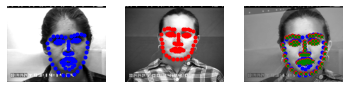

In [29]:
# Show result - input transformed and superimposed on target...
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(target_X_img,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(input_Y_img,cmap=cm.gray)
plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=3)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(target_X_img,cmap=cm.gray)
plt.imshow(tr_Y_img,alpha=0.6,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=3) 
plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=3) # same as...
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=3)
plt.axis('off')
plt.show()

In [40]:

from scipy.spatial import procrustes

mtx1, mtx2, disparity = procrustes(lan,lan1)


### No dan iguales, ver porque luego. Ahora usamos el procurstres manual por ser el que nos permite transformar las imagenes

In [48]:
Z_pts

array([[251.95419768, 245.41676142],
       [257.12900208, 279.45549204],
       [264.83096202, 313.15331243],
       [270.18564075, 346.96592885],
       [284.34265861, 378.29346894],
       [306.46152116, 404.66597634],
       [334.25203222, 424.23521569],
       [367.85407289, 431.41229901],
       [402.1423096 , 432.60934321],
       [435.0729349 , 429.52725767],
       [465.4207601 , 416.55021356],
       [489.94803795, 394.80535357],
       [505.82298284, 365.94527584],
       [515.21204108, 334.18029919],
       [522.16998808, 302.02734591],
       [528.8169478 , 269.45832093],
       [531.13177024, 236.89038589],
       [275.04223741, 198.86359637],
       [294.14495308, 189.96077555],
       [314.5382126 , 185.70854403],
       [335.24308523, 188.93143593],
       [355.60765357, 193.42627459],
       [423.41642091, 187.7087978 ],
       [443.72259392, 183.48346306],
       [464.05374689, 180.35674343],
       [484.43202625, 182.14818646],
       [503.78891437, 188.87727265],
 

In [46]:
mtx2

array([[-0.16765001, -0.06310626],
       [-0.1614993 , -0.02264825],
       [-0.15234485,  0.01740456],
       [-0.14598034,  0.05759381],
       [-0.12915349,  0.09482934],
       [-0.10286328,  0.12617537],
       [-0.06983183,  0.14943512],
       [-0.02989287,  0.15796571],
       [ 0.0108617 ,  0.15938851],
       [ 0.05000263,  0.15572518],
       [ 0.08607368,  0.14030082],
       [ 0.1152265 ,  0.11445516],
       [ 0.13409526,  0.08015243],
       [ 0.14525497,  0.04239697],
       [ 0.1535251 ,  0.00418038],
       [ 0.1614256 , -0.03453076],
       [ 0.16417697, -0.0732406 ],
       [-0.14020785, -0.11843877],
       [-0.1175026 , -0.12902055],
       [-0.09326343, -0.1340747 ],
       [-0.06865388, -0.13024401],
       [-0.04444881, -0.1249015 ],
       [ 0.03614785, -0.13169722],
       [ 0.06028351, -0.1367194 ],
       [ 0.08444887, -0.14043578],
       [ 0.10867023, -0.1383065 ],
       [ 0.13167759, -0.13030839],
       [-0.00268289, -0.08538178],
       [-0.00090691,

In [ ]:
### Vamos a hacerlo con todas las imagenes ahora

In [30]:

even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )
target_X_img = cv2.imread(all_images[0],0)
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))

transformed_landmarks_total = []

for i in range(0, len(my_landmarks)):
    even1 = np.asarray(my_landmarks.iloc[i][::2] )
    odds1 = np.asarray( my_landmarks.iloc[i][1::2] )
    lan1 =[]
    for (a, b) in zip(even1, odds1):
        lan1.append(np.asarray([a,b]))
    
    X_pts = np.asarray(lan)
    Y_pts = np.asarray(lan1)
    
    input_Y_img = cv2.imread(all_images[i])
    
    r,s,tr, d= opa(X_pts,Y_pts)

    
    # Build and apply transform matrix...
    # Note: for affine need 2x3 (a,b,c,d,e,f) form
    R = np.eye(3)
    R[0:2,0:2] = r
    S = np.eye(3) * s
    S[2,2] = 1
    t = np.eye(3)
    t[0:2,2] = tr
    M = np.dot(np.dot(R,S),t.T).T
    tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(640,490))

    
    #transform deberia hacer el a[1] = a[1].dot(r) * s + t
    Z_pts = Y_pts.dot(r) * s + tr
 
   

    transformed_landmarks_total.append(Z_pts)
    filename = 'warped_image_procustres_'+ str(i) + '.png'
    path = '../ck+warped'
    cv2.imwrite(os.path.join(path , filename), tr_Y_img)
  
      
transformed_landmarks_total = np.asarray(transformed_landmarks_total) 

In [31]:
transformed_landmarks_total[0]

array([[258.21331, 235.46651],
       [261.55523, 270.38882],
       [267.97811, 304.70225],
       [276.75035, 339.07949],
       [290.51988, 370.89977],
       [310.56404, 399.76081],
       [332.52056, 427.81513],
       [363.1268 , 443.66015],
       [397.90211, 448.08351],
       [430.61491, 441.72095],
       [454.77885, 417.60829],
       [475.50851, 391.01632],
       [491.64715, 361.52778],
       [503.51746, 329.86724],
       [510.63019, 297.13371],
       [515.33789, 263.56669],
       [517.22091, 229.90335],
       [276.5953 , 208.65122],
       [298.56746, 193.44809],
       [324.48271, 188.98008],
       [351.13502, 190.92712],
       [377.12293, 195.95614],
       [411.47442, 195.03525],
       [431.76316, 185.32552],
       [454.00509, 181.46308],
       [476.10079, 181.08416],
       [497.59387, 187.31143],
       [393.27418, 223.76881],
       [393.77468, 241.57579],
       [394.62736, 259.29851],
       [395.80941, 276.70295],
       [367.72783, 302.41526],
       [

In [44]:
len(transformed_landmarks_total)

583

In [50]:
transformed_final = transformed_landmarks_total[0].flatten('F')
for i in range (1, len(transformed_landmarks_total)):
    transformed_final = np.vstack((transformed_final, transformed_landmarks_total[i].flatten('F')))
transformed_final[0]


my_df = pd.DataFrame(transformed_final)
my_df.to_csv('transformed_landmarks_procustres_total.csv',header = False, index= False)

In [ ]:
#Ahora en el archivo arriba esta guardado los landmarks en orden x1-xn,y1-yn, listo para PCA.

### Ahora si, trabajamos con esta data alineada en orden xy. Luego de cargala, conseguimos la diferencia con cada frame 0 por secuencia, y con esos datos utilizamos PCA para  encontrar los b_shape, que tienen dimension #principal_component x 1 para cada frame . 

In [51]:
my_data = pd.read_csv('transformed_landmarks_procustres_total.csv',header = None)
my_data

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,258.213310,261.555230,267.978110,276.750350,290.519880,310.564040,332.520560,363.126800,397.902110,430.614910,...,399.276060,381.071370,361.327690,343.845490,342.421360,344.785120,356.986140,367.246760,371.105790,367.883230
1,258.260079,261.597406,268.016403,276.783427,290.547142,310.591197,332.539137,363.130286,397.902328,430.608304,...,399.365256,381.114874,361.348807,343.819469,342.387214,344.761274,357.004890,367.318464,371.202325,367.961851
2,258.260079,261.597406,268.016403,276.783427,290.547142,310.591197,332.539137,363.130286,397.902328,430.608304,...,399.365256,381.114874,361.348807,343.819469,342.387214,344.761274,357.004890,367.318464,371.202325,367.961851
3,258.180526,261.525672,267.951280,276.727163,290.500783,310.545016,332.507530,363.124348,397.901963,430.619539,...,399.213509,381.040850,361.312874,343.863722,342.445298,344.801846,356.972986,367.196473,371.038097,367.828110
4,257.731806,261.121102,267.584058,276.409971,290.239485,310.284590,332.329299,363.091027,397.899820,430.682774,...,398.354396,380.621481,361.109119,344.113637,342.773430,345.030917,356.792047,366.505904,370.108661,367.071109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,262.385668,261.062593,266.861863,273.905367,280.123096,297.593762,326.445073,361.495379,398.277240,435.267238,...,382.551530,377.499012,358.141953,345.109024,345.145549,345.665832,354.898678,365.431509,368.794873,369.979998
579,262.459289,261.098531,266.925632,273.945526,280.136290,297.623928,326.464264,361.513025,398.281893,435.260389,...,382.492036,377.440158,358.135715,345.078815,345.125768,345.676078,354.905526,365.450687,368.767366,369.982708
580,262.346649,261.055020,266.834543,273.898203,280.120631,297.541858,326.397965,361.458747,398.250373,435.267297,...,382.482054,377.545025,358.167304,345.151649,345.217583,345.715374,354.863787,365.350292,368.692327,369.956275
581,262.326839,261.042689,266.813314,273.890577,280.132540,297.586126,326.448584,361.489296,398.281757,435.275927,...,382.789229,377.648590,358.193143,345.063979,345.084160,345.576679,354.930971,365.574745,369.051948,370.137988


In [52]:
cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq =np.asarray(cant_frames_per_seq).flatten()

In [53]:
#### Aqui hacemos las diferencias entre los landmarks de una secuencia, siempre contra su frame 0

ind =0
my_data_aligned_diff =[]
for i in range(0, len(cant_frames_per_seq)):#51
    cant_frames = cant_frames_per_seq[i]
    frame_zero = my_data.iloc[ind]    
    for j in range(ind, ind + cant_frames):
        my_data_aligned_diff.append(my_data.iloc[j]- my_data.iloc[ind]) #no dice nada de abs
    ind = ind + cant_frames
    
my_data_aligned_diff = np.asarray(my_data_aligned_diff)

In [54]:
my_df = pd.DataFrame(my_data_aligned_diff)
my_df.to_csv('my_data_aligned_diff.csv',header = False, index= False)

# Ahora hacemos PCA

En el paper nos dice que restaramos el mean por columna, nosotros tambien normalizamos por standard deviation (dividimos).
La cantidad de xomponentes es la minima que alcanze un 99% loadings, en este caso 38.

In [3]:
my_data_forPCA = pd.read_csv('my_data_aligned_diff.csv',header = None)
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.046769,0.042176,0.038293,0.033077,0.027262,0.027157,0.018577,0.003486,0.000218,-0.006606,...,0.089196,0.043504,0.021117,-0.026021,-0.034146,-0.023846,0.018750,0.071704,0.096535,0.078621
2,0.046769,0.042176,0.038293,0.033077,0.027262,0.027157,0.018577,0.003486,0.000218,-0.006606,...,0.089196,0.043504,0.021117,-0.026021,-0.034146,-0.023846,0.018750,0.071704,0.096535,0.078621
3,-0.032784,-0.029558,-0.026830,-0.023187,-0.019097,-0.019024,-0.013030,-0.002452,-0.000147,0.004629,...,-0.062551,-0.030520,-0.014816,0.018232,0.023938,0.016726,-0.013154,-0.050287,-0.067693,-0.055120
4,-0.481504,-0.434128,-0.394052,-0.340379,-0.280395,-0.279450,-0.191261,-0.035773,-0.002290,0.067864,...,-0.921664,-0.449889,-0.218571,0.268147,0.352070,0.245797,-0.194093,-0.740856,-0.997129,-0.812121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,3.098186,2.988080,3.345981,4.404354,2.801976,0.717847,0.503815,-0.033916,-0.314410,0.038284,...,12.470661,10.024959,4.949259,-7.416548,-5.575409,-4.965306,4.683216,14.586773,18.033447,17.151559
579,3.171807,3.024018,3.409750,4.444514,2.815170,0.748013,0.523005,-0.016271,-0.309756,0.031435,...,12.411167,9.966105,4.943021,-7.446757,-5.595191,-4.955060,4.690065,14.605951,18.005940,17.154269
580,3.059167,2.980506,3.318661,4.397191,2.799512,0.665942,0.456706,-0.070549,-0.341276,0.038343,...,12.401185,10.070972,4.974610,-7.373922,-5.503375,-4.915764,4.648326,14.505556,17.930901,17.127836
581,3.039358,2.968175,3.297432,4.389565,2.811420,0.710211,0.507325,-0.039999,-0.309893,0.046973,...,12.708360,10.174537,5.000449,-7.461592,-5.636798,-5.054459,4.715510,14.730009,18.290522,17.309550


In [4]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

(583, 136)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=29)
pca.fit_transform(scaled_landDiff)
b_shape = pca.fit_transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 5 componentes proncipales (de 136 2*l landmarks)

(583, 29)

In [6]:
print(sum(pca.explained_variance_ratio_))

0.9903858143171537


In [7]:
my_df = pd.DataFrame(b_shape)
my_df.to_csv('pca_shapepoints.csv',header = False, index= False)

In [ ]:
cada fila deberia ser el b de 1 frame en 5 componentes proncipales (de 136 puntos que eran 2*l landmarks)

## Aca deberiamos graficar el impacto de los principal componentes.

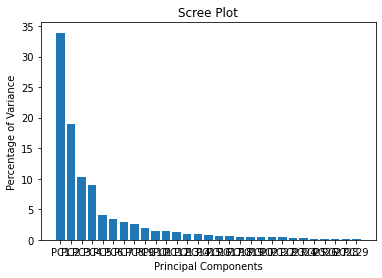

In [69]:
b_shape
pca_var=np.round(pca.explained_variance_ratio_* 100, decimals=1 )
labels = ['PC'+ str(s) for s in range(1, len(pca_var)+1)]

plt.bar(x= range(1, len(pca_var)+1), height = pca_var, tick_label= labels)
plt.ylabel("Percentage of Variance")
plt.xlabel("Principal Components")
plt.title("Scree Plot")
plt.show()

## Aqui hacemos procustres con spicy, tenemos que ver porque cambia el res

In [70]:

from scipy.spatial import procrustes

aligned_data = []
for i in range(1, len(intercalated_data)):
    mtx1, mtx2, disparity = procrustes(intercalated_data[0], intercalated_data[i])
    if(i == 1):
        aligned_data.append(mtx1)
        aligned_data.append(mtx2)
    else:
        aligned_data.append(mtx2)


68

In [ ]:
aligned_data[0]

In [75]:
aligned_data[0].flatten().shape

(136,)

In [79]:
aligned_data_intercalated = []
for i in range(0, len(aligned_data)):
    aligned_data_intercalated.append(aligned_data[i].flatten())
#np.asarray(aligned_data_intercalated).shape
aligned_data_intercalated = np.asarray(aligned_data_intercalated)

(965, 136)

In [80]:
my_df = pd.DataFrame(aligned_data_intercalated)
my_df.to_csv('ckmock_landmark_aligned_intercalated_data.csv',header = False, index= False)

In [84]:
aligned_data_xy = []
for i in range(0, len(aligned_data)):
    aligned_data_xy.append(aligned_data[i].flatten('F'))
#np.asarray(aligned_data_intercalated).shape
aligned_data_xy = np.asarray(aligned_data_xy)
aligned_data_xy[0][68]

-0.06800458899401303

In [86]:
my_df = pd.DataFrame(aligned_data_xy)
my_df.to_csv('ckmock_landmark_aligned_xy.csv',header = False, index= False)

### Ahora si, trabajamos con esta data alineada en orden xy. Luego de cargala, conseguimos la diferencia con cada frame 0 por secuencia, y con esos datos utilizamos PCA para  encontrar los b_shape, que tienen dimension #principal_component x 1 para cada frame . 

In [2]:
my_data = pd.read_csv('ckmock_landmark_aligned_xy.csv',header = None)
my_data

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
1,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
2,-0.163450,-0.156895,-0.145752,-0.136284,-0.122597,-0.098510,-0.067956,-0.033574,0.005142,0.044869,...,0.087766,0.081893,0.069788,0.067553,0.066924,0.067827,0.070162,0.071911,0.072451,0.071782
3,-0.163462,-0.156908,-0.145755,-0.136281,-0.122597,-0.098517,-0.067972,-0.033580,0.005137,0.044863,...,0.087772,0.081898,0.069807,0.067551,0.066919,0.067826,0.070184,0.071954,0.072516,0.071826
4,-0.163406,-0.156854,-0.145720,-0.136245,-0.122544,-0.098467,-0.067924,-0.033558,0.005157,0.044874,...,0.087870,0.081942,0.069783,0.067510,0.066874,0.067786,0.070165,0.071976,0.072554,0.071843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.148756,-0.148653,-0.147350,-0.142510,-0.125884,-0.099116,-0.067693,-0.034620,0.002989,0.042856,...,0.087104,0.081242,0.062722,0.061722,0.062258,0.058505,0.057794,0.058807,0.063288,0.062188
961,-0.148750,-0.148671,-0.147348,-0.142510,-0.125914,-0.099120,-0.067702,-0.034628,0.002981,0.042855,...,0.087195,0.081358,0.062807,0.061829,0.062320,0.058664,0.057920,0.058891,0.063298,0.062257
962,-0.148761,-0.148685,-0.147358,-0.142514,-0.125920,-0.099120,-0.067688,-0.034631,0.002974,0.042849,...,0.087149,0.081329,0.062785,0.061839,0.062338,0.058680,0.057926,0.058856,0.063253,0.062230
963,-0.148763,-0.148652,-0.147356,-0.142512,-0.125875,-0.099113,-0.067682,-0.034619,0.002988,0.042853,...,0.087044,0.081181,0.062667,0.061684,0.062242,0.058448,0.057757,0.058756,0.063262,0.062147


In [3]:
cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq =np.asarray(cant_frames_per_seq).flatten()

In [4]:
ind =0
my_data_aligned_diff =[]
for i in range(0, len(cant_frames_per_seq)):#51
    cant_frames = cant_frames_per_seq[i]
    frame_zero = my_data.iloc[ind]    
    for j in range(ind, ind + cant_frames):
        my_data_aligned_diff.append(my_data.iloc[j]- my_data.iloc[ind]) #no dice nada de abs
    ind = ind + cant_frames
    
my_data_aligned_diff = np.asarray(my_data_aligned_diff)

In [7]:
my_df = pd.DataFrame(my_data_aligned_diff)
my_df.to_csv('my_data_aligned_diff.csv',header = False, index= False)

# Ahora hacemos PCA

En el paper nos dice que restaramos el mean por columna, nosotros tambien normalizamos por standard deviation (dividimos).
La cantidad de xomponentes es la minima que alcanze un 99% loadings, en este caso 38.

In [17]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_aligned_diff)
scaled_landDiff.shape

(965, 136)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=38)
pca.fit_transform(scaled_landDiff)
b_shape = pca.fit_transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 38 componentes proncipales (de 136 2*l landmarks)

(965, 38)

In [19]:
print(sum(pca.explained_variance_ratio_))


0.9907696428747979


 cada fila deberia ser el b de 1 frame en 38 componentes proncipales (de 136 2*l landmarks)

## Aca deberiamos graficar el impacto de los principal componentes.

### Aca vamos a hacerlo con otra implementacion de procustres (que es robada de Matlab)

In [2]:
def procru(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection != 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}
   
    return d, Z, tform


In [7]:
import matplotlib.cm as cm 
my_landmarks = pd.read_csv('ckmock_landmark_intercalated_data.csv',header = None)
even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )

even1 = np.asarray(my_landmarks.iloc[300][::2] )
odds1 = np.asarray( my_landmarks.iloc[300][1::2] )

lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))
    
lan1 =[]
for (a, b) in zip(even1, odds1):
    lan1.append(np.asarray([a,b]))

    

# Open images...
target_X_img = cv2.imread(all_images[0],0)
input_Y_img = cv2.imread(all_images[300],0)

# Landmark points - same number and order!
# l eye, r eye, nose tip, l mouth, r mouth
X_pts = np.asarray(lan)
Y_pts = np.asarray(lan1)

# Calculate transform via procrustes...

dist, Z, transfm = procru(X_pts,Y_pts)


In [13]:
transfm['rotation']

array([[ 1.00000000e+00,  1.73472348e-18],
       [-1.73472348e-18,  1.00000000e+00]])

In [30]:

even = np.asarray(my_landmarks.iloc[0][::2] )
odds = np.asarray( my_landmarks.iloc[0][1::2] )
target_X_img = cv2.imread(all_images[0],0)
lan =[]
for (a, b) in zip(even, odds):
    lan.append(np.asarray([a,b]))

transformed_landmarks_total = []

for i in range(0, len(my_landmarks)):
    even1 = np.asarray(my_landmarks.iloc[i][::2] )
    odds1 = np.asarray( my_landmarks.iloc[i][1::2] )
    lan1 =[]
    for (a, b) in zip(even1, odds1):
        lan1.append(np.asarray([a,b]))
    
    X_pts = np.asarray(lan)
    Y_pts = np.asarray(lan1)
    
    input_Y_img = cv2.imread(all_images[i])
    
    dist, Z, transm = procru(X_pts,Y_pts)

    
    # Build and apply transform matrix...
    # Note: for affine need 2x3 (a,b,c,d,e,f) form
    R = np.eye(3)
    R[0:2,0:2] = transm['rotation']
    S = np.eye(3) * transm['scale']
    S[2,2] = 1
    t = np.eye(3)
    t[0:2,2] = transm['translation']
    M = np.dot(np.dot(R,S),t.T).T
    tr_Y_img = cv2.warpAffine(input_Y_img,M[0:2,:],(700,700))

    
    #transform deberia hacer el a[1] = a[1].dot(r) * s + t
    Z_pts = Z
 
   

    transformed_landmarks_total.append(Z_pts)
    filename = 'warped_image_procustres_matlab'+ str(i) + '.png'
    path = '../ck+warped2'
    cv2.imwrite(os.path.join(path , filename), tr_Y_img)
  
      
transformed_landmarks_total = np.asarray(transformed_landmarks_total) 

error: /build/opencv-L2vuMj/opencv-3.2.0+dfsg/modules/imgproc/src/imgwarp.cpp:5987: error: (-215) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function warpAffine


In [17]:
transformed_landmarks_total =transformed_landmarks_total.flatten('F').reshape((583,136))
transformed_landmarks_total.shape

my_df = pd.DataFrame(transformed_landmarks_total)
my_df.to_csv('transformed_landmarks_procustres_matlabtotal.csv',header = False, index= False)

my_data = pd.read_csv('transformed_landmarks_procustres_matlabtotal.csv',header = None)
my_data

cant_frames_per_seq = pd.read_csv('ckmock_landmark_FramePerSeq.csv',header = None)
cant_frames_per_seq =np.asarray(cant_frames_per_seq).flatten()

In [18]:
ind =0
my_data_aligned_diff =[]
for i in range(0, len(cant_frames_per_seq)):#51
    cant_frames = cant_frames_per_seq[i]
    frame_zero = my_data.iloc[ind]    
    for j in range(ind, ind + cant_frames):
        my_data_aligned_diff.append(my_data.iloc[j]- my_data.iloc[ind]) #no dice nada de abs
    ind = ind + cant_frames
    
my_data_aligned_diff = np.asarray(my_data_aligned_diff)

In [19]:
my_df = pd.DataFrame(my_data_aligned_diff)
my_df.to_csv('my_data_aligned_diffmatlab.csv',header = False, index= False)
my_data_forPCA = pd.read_csv('my_data_aligned_diffmatlab.csv',header = None)
my_data_forPCA

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,98.984509,110.135931,119.659090,130.068933,126.234913,126.461903,127.892426,121.712927,131.918205,131.957791,...,-3.575629,-13.191900,-21.141358,-18.555467,10.906332,0.874012,7.967640,26.299500,34.487153,48.072209
2,149.774144,154.924340,165.224491,180.153036,185.741604,173.584153,164.593856,150.733989,156.553032,162.470642,...,-203.119019,-204.173367,-210.201030,-214.932742,-197.098089,-202.961914,-192.838598,-178.551837,-162.366212,-165.046987
3,-27.314395,-28.480626,-44.033572,-29.513421,-13.548740,-14.124843,-28.485688,-25.159331,5.486219,8.312848,...,-22.371393,1.422362,-20.261845,-23.102855,-19.460906,13.404109,-3.821607,14.030001,9.887492,12.761397
4,101.857481,110.141746,111.811546,133.016040,103.441020,101.497109,74.928959,82.872785,93.336090,86.480747,...,-38.331805,-57.658081,-56.351277,-47.408464,-13.055396,-45.412661,-31.033062,3.471903,54.551376,53.620553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,-216.153514,-218.428533,-206.546247,-220.625991,-217.342451,-230.689068,-230.021847,-217.915505,-249.248294,-243.957430,...,-88.732101,-48.632295,-64.529786,-64.585646,-62.247526,-28.352667,-50.136747,-36.703970,-54.399413,-2.446680
579,-6.733685,-11.746728,-3.399737,5.734773,13.118984,2.879736,3.196615,17.041965,5.480246,12.492916,...,-73.751178,-61.603878,-73.971465,-79.787493,-65.903371,-62.476912,-112.297205,-94.334181,-120.280252,-90.400603
580,-117.403642,-118.440577,-119.976114,-132.593849,-126.346920,-37.283623,-29.708467,-30.137197,-63.552083,-33.775583,...,-107.398321,-87.313036,-129.833237,-90.090243,-77.604258,-97.543276,-110.633395,-59.664575,-85.223965,-51.822219
581,-69.752924,-39.615474,-36.071905,-47.944584,-43.741958,-54.771118,-31.779199,-21.689424,-59.510480,-47.587148,...,-101.284768,-103.507022,-114.809831,-119.462304,-110.889640,-117.442794,-140.950898,-136.498565,-222.822991,-200.507038


In [20]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_landDiff = std_scaler.fit_transform(my_data_forPCA)
scaled_landDiff.shape

(583, 136)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit_transform(scaled_landDiff)
b_shape = pca.fit_transform(scaled_landDiff)
b_shape.shape # cada fila deberia ser el b de 1 frame en 38 componentes proncipales (de 136 2*l landmarks)

(583, 5)

In [26]:
print(sum(pca.explained_variance_ratio_))

0.8272032696757701


EXTRA

In [ ]:
subjects_landmarks = '../ck+copy/Landmarks/'
sorted_subjects =   np.sort(os.listdir('../ck+copy/Landmarks/')) # we probably need to not have the sorted

distances = []
for subject in sorted_subjects:
    one_subject_landmarks = '../ck+copy/Landmarks/' + str(subject)+ '/'
    sorted_list = np.sort(os.listdir(one_subject_landmarks)) #creo que este sort se puede quitar
    distances_per_subject = []
    for emotion in sorted_list:
        matrix_landmark_per_frame = []
        subject_landmark_emotion = one_subject_landmarks + str(emotion)    
        for i in range(0, len(os.listdir(subject_landmark_emotion))):
            data = pd.read_csv('../ck+copy/Landmarks/' +  str(subject)+ '/' + str(emotion)+'/'+ str(subject)+ '_'+str(emotion)+'_'+ str(i+1).zfill(8)+'_landmarks.txt',  header=None)
            data.columns =['landmarks']
            quantity_of_landmarks = data.size #68
            data = data['landmarks'].str.split('   ', expand=True)
            data.columns =['landmarks', 'landmarkX', 'landmarkY']
            data =data.drop(columns=['landmarks'])
            landmarkXY=data['landmarkX'].append(data['landmarkY'], ignore_index=True)
            landmarkXY_array =landmarkXY.to_numpy(dtype=float)
            matrix_landmark_per_frame.append(landmarkXY_array)
        frame0 = matrix_landmark_per_frame[0]
        distance_landmark_per_frame = matrix_landmark_per_frame
        for i in range(0, len(distance_landmark_per_frame)):
            distance_landmark_per_frame[i] = distance_landmark_per_frame[i] - frame0
        distances_per_subject.append(distance_landmark_per_frame)
    distances.append(distances_per_subject)
#tenemos matrix que por cada sujeto tiene una matriz con cada emocion, que por cada distancia por emocion tiene vector con la distancia de frames con el primero por emocion